<a href="https://colab.research.google.com/github/kamil3di/thyroid_prediction/blob/main/thyroid_main_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Kaggle üzerinden indirme yapabilmek için JSON izin dosyası karşı tarafa yüklendi
!pip install -q kaggle
 
from google.colab import files
files.upload()

In [ ]:
#Kaggle dosyası oluşturuldu ve veri seti indirildi
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
 
!chmod 600 ~/.kaggle/kaggle.json
 
!kaggle datasets download -d kamildinleyici/thyroid-dataset
 
!unzip /content/thyroid-dataset.zip

In [1]:
#Kütüphaneler eklendi
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.models import Model
from keras.preprocessing import image
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [2]:
#Model oluşturuldu
base_model = InceptionResNetV2(weights='imagenet',include_top = False,  input_shape=(224,224,3))
 
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2,activation='softmax')(x)
 
for layer in base_model.layers:
    layer.trainable = True
 
model = Model(inputs = base_model.input, outputs = x)

In [ ]:
#Model özeti
model.summary()

In [3]:
#Model derlendi
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [4]:
#Rescale ve Data Augmentation işlemleri gerçekleştirildi
BATCH_SIZE = 32
TARGET_SIZE = (224,224)
TRAIN_DATA_DIR = '/content/thyroid/thyroid/train'
TEST_DATA_DIR = '/content/thyroid/thyroid/test'
 
train_datagen = image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split = 0.2,
    horizontal_flip=True)
 
val_datagen = image.ImageDataGenerator(rescale = 1./255, 
                                       validation_split = 0.2)
                                         
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    seed = 42,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset = 'training',
    shuffle = True) 
 
validation_generator = val_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    seed = 42,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset = 'validation',
    shuffle = True)

Found 32 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [ ]:
#Model eğitildi
initial_epochs = 120

history = model.fit(
    train_generator,
    #steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = initial_epochs,
    #validation_steps = validation_generator.samples // BATCH_SIZE,
    validation_data = validation_generator)

In [6]:
 #Train ve validation veri setlerinden sonra test veri seti oluşturuluyor
test_datagen = image.ImageDataGenerator(rescale = 1./255)
 
test_generator = test_datagen.flow_from_directory(
     TEST_DATA_DIR,
     target_size = (224,224),
     batch_size =32,
     class_mode ='categorical',
     shuffle = False)

Found 10 images belonging to 2 classes.


In [7]:
#Modelin test veri seti üzerindeki başarı oranı gözlemleniyor
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 925ms/step - loss: 0.5669 - accuracy: 0.9000
Test accuracy : 0.8999999761581421


**Test veri seti üzerinde %90 başarı oranı elde edildi**

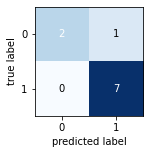

In [8]:
#Confusion matrix oluşturuldu
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

Y_pred = model.predict(test_generator)

y_pred = np.argmax(Y_pred, axis=1)
 
cm = confusion_matrix(test_generator.classes, y_pred)
 
fig,ax = plot_confusion_matrix(conf_mat= cm, figsize=(2,2),show_normed = False)
plt.show()

In [9]:
#Bening olan görseller 0 ile Maling olan görseller 1 ile gösteriliyor
test_generator.class_indices

{'bening': 0, 'maling': 1}

In [10]:
#Görselleştirme için fonksiyon oluşturuldu
def decide_dis(sample):
  if sample == 0:
    sample = "bening"
  else:
    sample = "maling"
  return sample

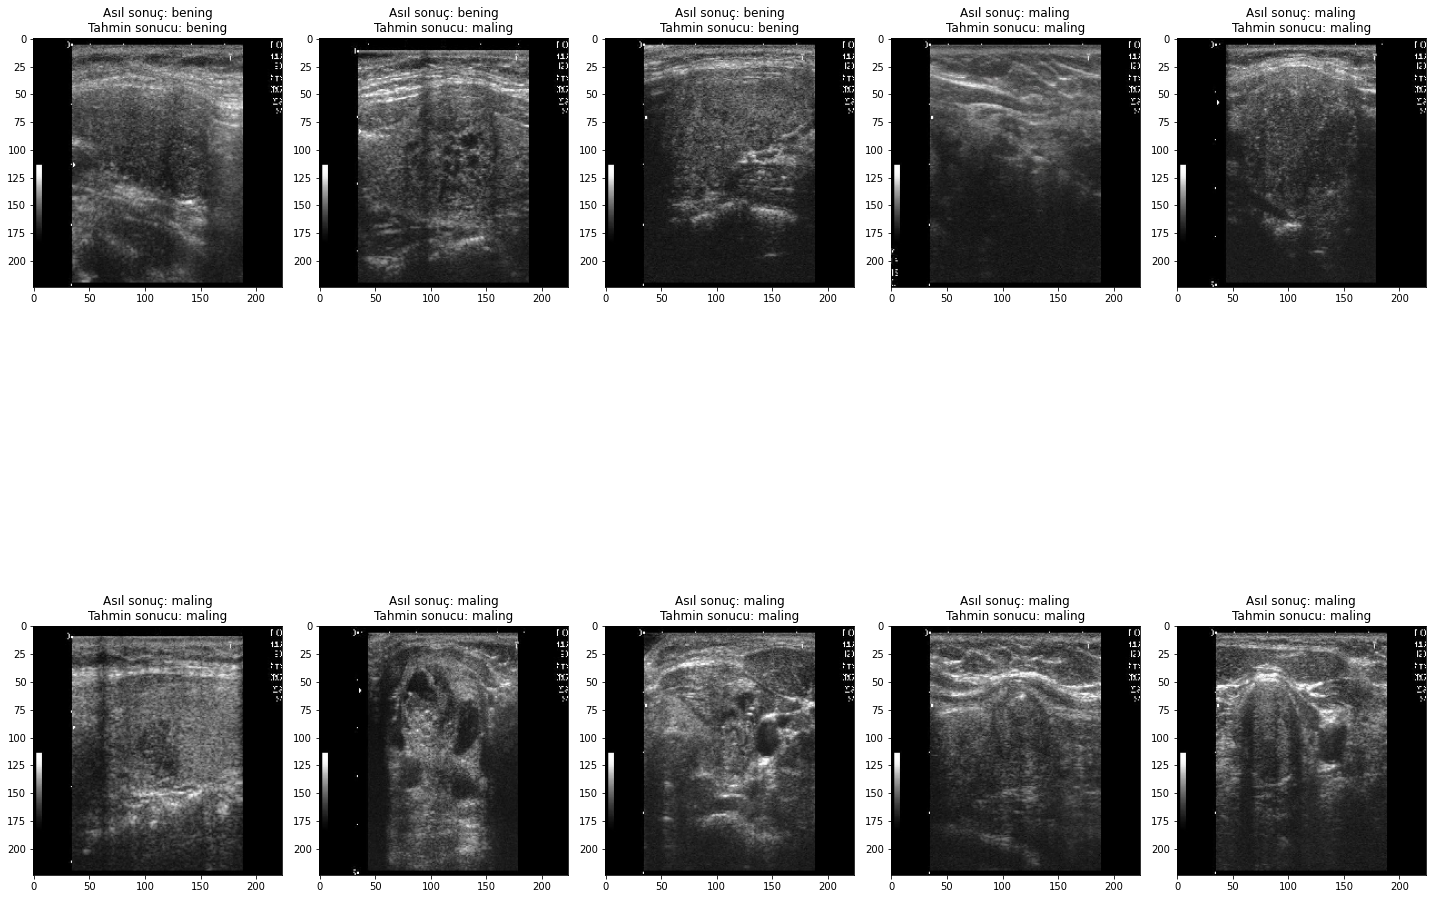

In [11]:
#Görselleştirme sağlanıldı
def plotImages(images_arr):
    fig, axes = plt.subplots(2,5, figsize=(20,20))
    axes = axes.flatten()
    i = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.set_title("Asıl sonuç: " + decide_dis(test_generator.classes[i]) + "\n" + "Tahmin sonucu: " + decide_dis(y_pred[i]))
        i += 1
    plt.tight_layout()
    plt.show()

augmented_images = [test_generator[0][0][i] for i in range(10)]
plotImages(augmented_images)

In [12]:
#Precision,Recall,F1-Score metrikleri görüntülendi
from sklearn.metrics import classification_report

target_names = ['Benign', 'Malign']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Benign       1.00      0.67      0.80         3
      Malign       0.88      1.00      0.93         7

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10



In [13]:
#Model sonrasında kullanılmak üzere kaydedildi
model.save("thyroid_model.h5")